# Librerías y descargas

In [1]:
import os
import sys
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pickle

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

#!pip install --upgrade pillow
from PIL import Image, UnidentifiedImageError

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import datasets, models, transforms
import torchsummary as ts
from google.colab import drive
drive.mount("gdrive", force_remount = True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.backends.cudnn.deterministic = True
random_state = 3380
torch.manual_seed(random_state)
torch.cuda.manual_seed_all(random_state)
torch.autograd.set_detect_anomaly(True)

!rm -r Images
!unzip -qqq /content/gdrive/MyDrive/MDS/Procesamiento\ Avanzado\ de\ Imágenes/Proyecto/Images_256.zip
#!unzip -qqq /content/gdrive/MyDrive/Images_256.zip
!rm -r __MACOSX
!rm -r Images/.DS_Store

!mkdir best_models
!mkdir models

# Import de github
!git clone https://github.com/sebatinoco/EL7008

!rm -r model
!rm -r utils
!mv EL7008/* .

from utils.gen_valsplit import gen_valsplit
from utils.evaluate import evaluate
from utils.fit import fit
from utils.graph_metrics import graph_metrics
from utils.YogaDataset import YogaDataset

from model.gen_patches import gen_patches
from model.MultiHeadSelfAttention import MultiHeadSelfAttention
from model.MultiLayerPerceptron import MultiLayerPerceptron
from model.EncoderBlock import EncoderBlock
from model.ViT import ViT

!rm -r EL7008

Mounted at gdrive
rm: cannot remove 'Images': No such file or directory
rm: cannot remove '__MACOSX': No such file or directory
rm: cannot remove 'Images/.DS_Store': No such file or directory
Cloning into 'EL7008'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 46 (delta 15), reused 41 (delta 10), pack-reused 0
Unpacking objects: 100% (46/46), done.
rm: cannot remove 'model': No such file or directory
rm: cannot remove 'utils': No such file or directory


# Lectura de imágenes

Lectura de la división original del dataset usando `yoga_train.txt` y `yoga_test.txt`

In [2]:
path = '/content/gdrive/MyDrive/MDS/Procesamiento Avanzado de Imágenes/Proyecto'
#path = '/content/gdrive/MyDrive'

f = open(os.path.join(path, 'yoga_train.txt'))
train_lines = f.readlines()

train_lines = [text.replace('\n', '') for text in train_lines]
train_lines = [text.split(',') for text in train_lines]
df_train = pd.DataFrame(train_lines, columns = ['img_name', 'high', 'mid', 'low'])
df_train['split'] = 'train'
print(f'{df_train.shape[0]} datos originales en train')

f = open(os.path.join(path, 'yoga_test.txt'))
test_lines = f.readlines()

test_lines = [text.replace('\n', '') for text in test_lines]
test_lines = [text.split(',') for text in test_lines]
df_test = pd.DataFrame(test_lines, columns = ['img_name', 'high', 'mid', 'low'])
df_test['split'] = 'test'
print(f'{df_test.shape[0]} datos originales en test')

metadata = pd.DataFrame()
metadata = metadata.append([df_train, df_test])
print(f'{metadata.shape[0]} datos originales en total')
metadata.head()

20994 datos originales en train
7456 datos originales en test
28450 datos originales en total


,img_name,high,mid,low,split
0,Akarna_Dhanurasana/64.jpg,1,8,0,train
1,Akarna_Dhanurasana/229.jpg,1,8,0,train
2,Akarna_Dhanurasana/128.jpg,1,8,0,train
3,Akarna_Dhanurasana/145.jpg,1,8,0,train
4,Akarna_Dhanurasana/47.jpg,1,8,0,train


Luego, se trabaja con las imágenes descargadas en la sección anterior.

In [3]:
# primero borramos las imagenes con 0 kb
for folder in os.listdir('Images/'):
  !find "/content/Images/{folder}" -size 0 -delete

Filtramos todas las imágenes que pesan 0 kb

In [4]:
imgs = []
for folder in sorted(os.listdir('Images')):
  imgs += [f'{folder}/{image}' for image in os.listdir(f'Images/{folder}')]

df_download = pd.DataFrame(imgs, columns = ['img_name'])
print(f'{df_download.shape[0]} imágenes descargadas correctamente')

metadata = metadata.merge(df_download, on = 'img_name', how = 'inner')
metadata.head()

23093 imágenes descargadas correctamente


,img_name,high,mid,low,split
0,Akarna_Dhanurasana/64.jpg,1,8,0,train
1,Akarna_Dhanurasana/229.jpg,1,8,0,train
2,Akarna_Dhanurasana/128.jpg,1,8,0,train
3,Akarna_Dhanurasana/47.jpg,1,8,0,train
4,Akarna_Dhanurasana/121.jpg,1,8,0,train


Luego, se chequean las imágenes que no tienen problemas para ser leídas

In [5]:
# Verificamos lectura de imagenes

errors = []
for path in metadata['img_name']:
  try:
    # verificamos que imagen puede ser leida correctamente
    img_path = f'/content/Images/{path}'
    img = Image.open(img_path)
    img.verify()
    img.close()

    # assert de que imagenes estan en dimensiones 256x256
    img = Image.open(img_path)
    img_array = np.array(img)
    assert (img_array.shape[0] == 256) & (img_array.shape[1] == 256)
    img.close()
  except UnidentifiedImageError:
    errors.append(path)

print(f'{len(errors)} imágenes que no pueden ser leidas :(')

errors_df = pd.DataFrame(errors, columns = ['img_name'])
errors_df.head()

2829 imágenes que no pueden ser leidas :(


,img_name
0,Akarna_Dhanurasana/128.jpg
1,Akarna_Dhanurasana/30.jpg
2,Akarna_Dhanurasana/478.jpg
3,Akarna_Dhanurasana/207.jpg
4,Akarna_Dhanurasana/0_151.jpg


Consolidamos dataframe y printeamos distribución

In [6]:
metadata = metadata.merge(errors_df, on = 'img_name', how = 'left', indicator = True)
metadata = metadata[metadata['_merge'] == 'left_only'][['img_name', 'high', 'mid', 'low', 'split']]

print(f"{metadata[metadata['split'] == 'train'].shape[0]} imágenes finales en train")
print(f"{metadata[metadata['split'] == 'test'].shape[0]} imágenes finales en test")
print(f"{metadata.shape[0]} imágenes finales en total")

metadata.head()

15118 imágenes finales en train
5146 imágenes finales en test
20264 imágenes finales en total


,img_name,high,mid,low,split
0,Akarna_Dhanurasana/64.jpg,1,8,0,train
1,Akarna_Dhanurasana/229.jpg,1,8,0,train
3,Akarna_Dhanurasana/47.jpg,1,8,0,train
4,Akarna_Dhanurasana/121.jpg,1,8,0,train
5,Akarna_Dhanurasana/56.jpg,1,8,0,train


Graficamos distribución de clases

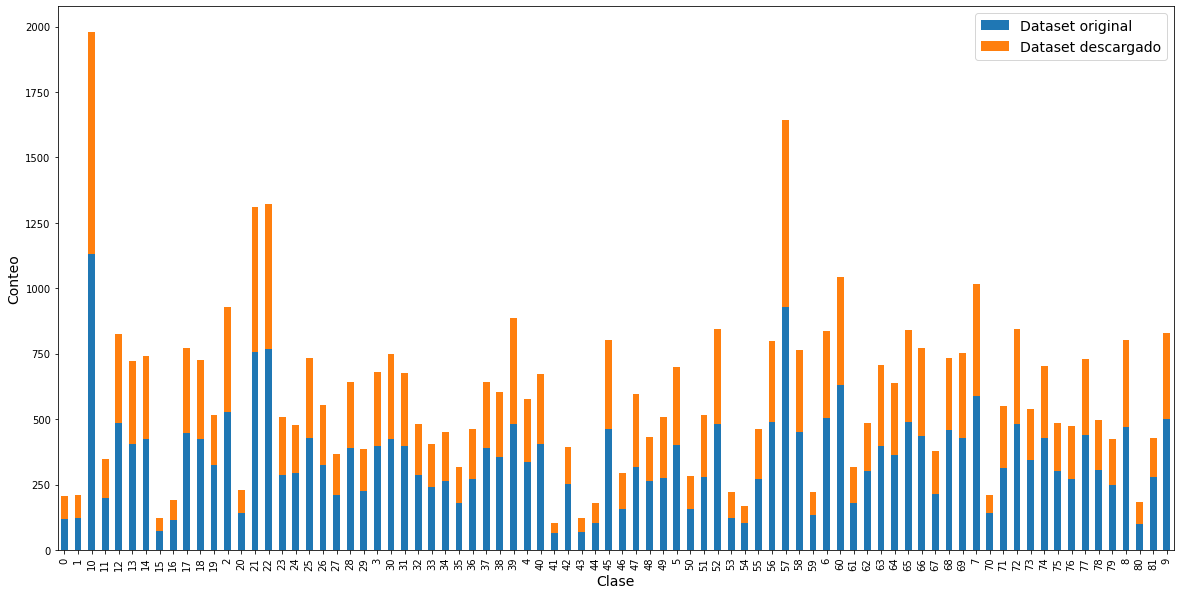

In [8]:
df_plot = df_train.append(df_test)

df_plot = df_plot.merge(metadata, indicator = True, how = 'outer')
df_plot['Dataset original'] = df_plot['_merge'].apply(lambda x: 1 if x in ['both', 'left_only'] else 0)
df_plot['Dataset descargado'] = df_plot['_merge'].apply(lambda x: 1 if x in ['both', 'right_only'] else 0)

df_plot.groupby('low').sum()[['Dataset original', 'Dataset descargado']].plot(kind = 'bar', stacked = True, figsize = (20, 10))
plt.xlabel('Clase', fontsize = 14)
plt.ylabel('Conteo', fontsize = 14)
plt.legend(fontsize = 14)
plt.show()

Se crea un archivo para guardar los scores obtenidos y así guardar los *checkpoints*

In [7]:
checkpoints_folder = '/content/gdrive/MyDrive/MDS/Procesamiento Avanzado de Imágenes/Proyecto/Checkpoints/'
#checkpoints_folder = '/content/gdrive/MyDrive/Checkpoints'
path_checkpoints = os.path.join(checkpoints_folder, 'checkpoints_dict.pkl')

if os.path.exists(path_checkpoints) is not True:

  print('Generando nuevo diccionario de checkpoints')

  checkpoints_dict = {'vit_t16_6': 0, 'vit_s16_6': 0,
                      'vit_t16_20': 0, 'vit_s16_20': 0,
                      'vit_t16_82': 0, 'vit_s16_82': 0,
                      }

  with open(path_checkpoints, 'wb') as f:
      pickle.dump(checkpoints_dict, f)

# Entrenamiento

## 6 clases

Generamos dataframe relevante al problema

In [9]:
metadata_high = gen_valsplit(metadata, class_level = 'high', val_size = .2)
n_classes = len(metadata_high['labels'].unique())
metadata_high.head()

,img_name,split,labels
8500,Locust_Pose_or_Salabhasana_/260.jpg,train,4
13067,Standing_big_toe_hold_pose_or_Utthita_Padangus...,train,0
10521,Scale_Pose_or_Tolasana_/1_138.jpg,train,2
13861,Supta_Baddha_Konasana_/2_587.jpg,train,4
12735,Standing_Forward_Bend_pose_or_Uttanasana_/1_16...,train,0


Comenzamos calculando la media y desviación estándar de los datos

In [10]:
train_dataset = YogaDataset(root = './Images', metadata = metadata_high, split = 'train', transform = transforms.Compose([transforms.ToTensor()]))
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = False, num_workers = 2, pin_memory = True)

nb_samples = 0.
channel_mean = torch.Tensor([0., 0., 0.])
channel_std = torch.Tensor([0., 0., 0.])
for batch in train_loader:
    images, labels = batch
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(2)*images.size(3), 3)
    for i in range(3):
        channel_mean[i]+=images[:, :, i].mean(1).sum(0)
        channel_std[i]+=images[:, :, i].std(1).sum(0)
    nb_samples += batch_samples

channel_mean /= nb_samples
channel_std /= nb_samples

print(f'Medias: f{channel_mean}')
print(f'Std: {channel_std}')

Medias: ftensor([0.6420, 0.6420, 0.6420])
Std: tensor([0.2384, 0.2384, 0.2384])


Normalizamos los datos usando los estadísticos calculados

In [11]:
train_transformations = transforms.Compose([
                  transforms.RandomCrop((224, 224)),
                  transforms.RandAugment(num_ops = 2, magnitude = 0),
                  transforms.ToTensor(),
                  transforms.Normalize(mean = channel_mean, 
                                       std = channel_std),
                                       ])

eval_transformations = transforms.Compose([
                  transforms.CenterCrop((224, 224)),
                  transforms.ToTensor(),
                  transforms.Normalize(mean = channel_mean, 
                                       std = channel_std), 
                                       ])

train_dataset = YogaDataset(root = './Images', metadata = metadata_high, split = 'train', transform = train_transformations)
val_dataset = YogaDataset(root = './Images', metadata = metadata_high, split = 'validation', transform = eval_transformations)
test_dataset = YogaDataset(root = './Images', metadata = metadata_high, split = 'test', transform = eval_transformations)

### Fit

In [12]:
tiny_vit = ViT(img_size = 224, 
            n_channels = 3, 
            patch_size = 16, 
            embedding_dim = 192, 
            mlp_dim = 768, 
            n_blocks = 12, 
            heads = 3, 
            n_classes = n_classes,
            dropout = 0.1,
            dropout_2 = 0,
            )
tiny_vit.to(device)

ViT(
  (linear): Linear(in_features=768, out_features=192, bias=True)
  (blocks): ModuleList(
    (0): EncoderBlock(
      (attention): MultiHeadSelfAttention(
        (W_q): ModuleList(
          (0): Linear(in_features=192, out_features=192, bias=True)
          (1): Linear(in_features=192, out_features=192, bias=True)
          (2): Linear(in_features=192, out_features=192, bias=True)
        )
        (W_k): ModuleList(
          (0): Linear(in_features=192, out_features=192, bias=True)
          (1): Linear(in_features=192, out_features=192, bias=True)
          (2): Linear(in_features=192, out_features=192, bias=True)
        )
        (W_v): ModuleList(
          (0): Linear(in_features=192, out_features=192, bias=True)
          (1): Linear(in_features=192, out_features=192, bias=True)
          (2): Linear(in_features=192, out_features=192, bias=True)
        )
        (W_o): Linear(in_features=576, out_features=192, bias=True)
      )
      (mlp): MultiLayerPerceptron(
      

In [ ]:
name = 'vit_t16_6'

# cargamos modelo con mejor desempeño en validacion
tiny_vit = torch.load(f'{checkpoints_folder}/{name}.pt', map_location = device)

Epoch: 001 	 Avg Train Loss: 0.702 	 Train Accuracy: 74.36 %	Avg Val Loss: 0.531 	 Val Accuracy: 81.85 % 	 Total Val Loss: 6.37
Epoch: 008 	 Avg Train Loss: 0.564 	 Train Accuracy: 80.04 %	Avg Val Loss: 0.645 	 Val Accuracy: 77.12 % 	 Total Val Loss: 7.74
Epoch: 015 	 Avg Train Loss: 0.345 	 Train Accuracy: 88.01 %	Avg Val Loss: 0.486 	 Val Accuracy: 82.37 % 	 Total Val Loss: 5.83
Epoch: 022 	 Avg Train Loss: 0.304 	 Train Accuracy: 89.64 %	Avg Val Loss: 0.479 	 Val Accuracy: 82.87 % 	 Total Val Loss: 5.75
Epoch: 029 	 Avg Train Loss: 0.306 	 Train Accuracy: 89.21 %	Avg Val Loss: 0.477 	 Val Accuracy: 83.07 % 	 Total Val Loss: 5.72
Epoch: 036 	 Avg Train Loss: 0.297 	 Train Accuracy: 89.85 %	Avg Val Loss: 0.477 	 Val Accuracy: 83.10 % 	 Total Val Loss: 5.73
Epoch: 039 	 Avg Train Loss: 0.305 	 Train Accuracy: 89.66 %
39 épocas efectuadas


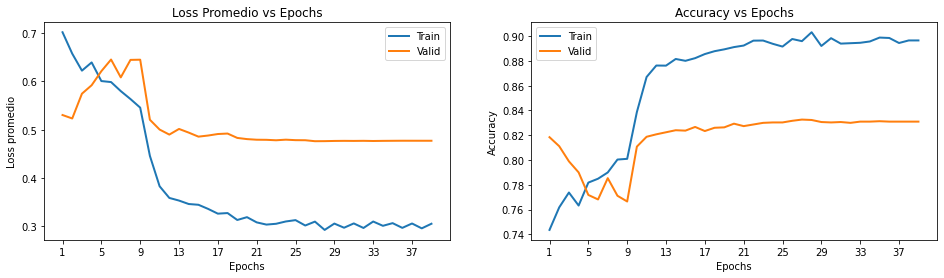

In [ ]:
# dataloader para cada set de datos
BATCH_SIZE = 256
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, 
                          num_workers = 2, pin_memory = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False, 
                          num_workers = 2, pin_memory = True)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, 
                          num_workers = 2, pin_memory = True)

# optimizador
lr = 2e-4
#optimizer = torch.optim.SGD(tiny_vit.parameters(), lr = lr, momentum = 0.9)
optimizer = torch.optim.Adam(tiny_vit.parameters(), lr = lr)

# scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size = 9, gamma = 0.1)
#scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)

# funcion de perdida
criterion = torch.nn.CrossEntropyLoss()

# epochs
epochs = 70

# patience
patience = 12

# clip
clip = 5

# nombre del modelo
name = 'vit_t16_6'

model_dict = {'model': tiny_vit,
              'trainloader': train_loader,
              'validloader': val_loader,
              'optimizer': optimizer,
              'scheduler': scheduler,
              'criterion': criterion,
              'epochs': epochs,
              'patience': patience,
              'clip': clip,
              'name': name,
              'random_state': random_state,
              'checkpoints_path': checkpoints_folder,
              }

train_acc, train_loss, valid_acc, valid_loss = fit(**model_dict)
graph_metrics(train_loss, train_acc, valid_loss, valid_acc)

### Evaluación

In [ ]:
# cargamos modelo con mejor desempeño en validacion
model = torch.load(f'{checkpoints_folder}/{name}.pt')

# obtenemos performance en conjunto de validación
accuracy, _, __ = evaluate(model = model, dataloader = val_loader, criterion = criterion)
print(f'Accuracy de la red en conjunto de validación: {accuracy * 100:.2f}%')

Accuracy de la red en conjunto de validación: 83.27%


In [ ]:
# obtenemos performance en conjunto de test
accuracy, _, __ = evaluate(model = model, dataloader = test_loader, criterion = criterion)
print(f'Accuracy de la red en conjunto de test: {accuracy * 100:.2f}%')

Accuracy de la red en conjunto de test: 65.66%


## 20 clases

Generamos dataframe relevante al problema

In [ ]:
metadata_mid = gen_valsplit(metadata, class_level = 'mid', val_size = .2)
n_classes = len(metadata_mid['labels'].unique())
metadata_mid.head()

,img_name,split,labels
5193,Extended_Revolved_Side_Angle_Pose_or_Utthita_P...,train,2
14094,Supta_Virasana_Vajrasana/4_82.jpg,train,13
12861,Standing_Forward_Bend_pose_or_Uttanasana_/1_26...,train,1
15931,Warrior_II_Pose_or_Virabhadrasana_II_/0_497.jpg,train,3
11824,Sitting pose 1 (normal)/3_57.jpg,train,4


Comenzamos calculando la media y desviación estándar de los datos

In [ ]:
train_dataset = YogaDataset(root = './Images', metadata = metadata_mid, split = 'train', transform = transforms.Compose([transforms.ToTensor()]))
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = False, num_workers = 2, pin_memory = True)

nb_samples = 0.
channel_mean = torch.Tensor([0., 0., 0.])
channel_std = torch.Tensor([0., 0., 0.])
for batch in train_loader:
    images, labels = batch
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(2)*images.size(3), 3)
    for i in range(3):
        channel_mean[i]+=images[:, :, i].mean(1).sum(0)
        channel_std[i]+=images[:, :, i].std(1).sum(0)
    nb_samples += batch_samples

channel_mean /= nb_samples
channel_std /= nb_samples

print(f'Medias: f{channel_mean}')
print(f'Std: {channel_std}')

Medias: ftensor([0.6446, 0.6446, 0.6446])
Std: tensor([0.2381, 0.2381, 0.2381])


Normalizamos los datos usando los estadísticos calculados

In [ ]:
train_transformations = transforms.Compose([
                  transforms.RandomCrop((224, 224)),
                  transforms.RandAugment(num_ops = 2, magnitude = 0),
                  transforms.ToTensor(),
                  transforms.Normalize(mean = channel_mean, 
                                       std = channel_std),
                                       ])

eval_transformations = transforms.Compose([
                  transforms.CenterCrop((224, 224)),
                  transforms.ToTensor(),
                  transforms.Normalize(mean = channel_mean, 
                                       std = channel_std), 
                                       ])

train_dataset = YogaDataset(root = './Images', metadata = metadata_mid, split = 'train', transform = train_transformations)
val_dataset = YogaDataset(root = './Images', metadata = metadata_mid, split = 'validation', transform = eval_transformations)
test_dataset = YogaDataset(root = './Images', metadata = metadata_mid, split = 'test', transform = eval_transformations)

### Fit

In [ ]:
tiny_vit = ViT(img_size = 224, 
            n_channels = 3, 
            patch_size = 16, 
            embedding_dim = 192, 
            mlp_dim = 768, 
            n_blocks = 12, 
            heads = 3, 
            n_classes = n_classes,
            dropout = 0.1,
            dropout_2 = 0,
            )
tiny_vit.to(device)

ViT(
  (linear): Linear(in_features=768, out_features=192, bias=True)
  (blocks): ModuleList(
    (0): EncoderBlock(
      (attention): MultiHeadSelfAttention(
        (W_q): ModuleList(
          (0): Linear(in_features=192, out_features=192, bias=True)
          (1): Linear(in_features=192, out_features=192, bias=True)
          (2): Linear(in_features=192, out_features=192, bias=True)
        )
        (W_k): ModuleList(
          (0): Linear(in_features=192, out_features=192, bias=True)
          (1): Linear(in_features=192, out_features=192, bias=True)
          (2): Linear(in_features=192, out_features=192, bias=True)
        )
        (W_v): ModuleList(
          (0): Linear(in_features=192, out_features=192, bias=True)
          (1): Linear(in_features=192, out_features=192, bias=True)
          (2): Linear(in_features=192, out_features=192, bias=True)
        )
        (W_o): Linear(in_features=576, out_features=192, bias=True)
      )
      (mlp): MultiLayerPerceptron(
      

Epoch: 001 	 Avg Train Loss: 3.034 	 Train Accuracy: 9.18 %	Avg Val Loss: 2.967 	 Val Accuracy: 10.71 % 	 Total Val Loss: 35.61
Epoch: 008 	 Avg Train Loss: 2.787 	 Train Accuracy: 14.45 %	Avg Val Loss: 2.782 	 Val Accuracy: 14.91 % 	 Total Val Loss: 33.38
Epoch: 015 	 Avg Train Loss: 2.557 	 Train Accuracy: 21.36 %	Avg Val Loss: 2.563 	 Val Accuracy: 20.34 % 	 Total Val Loss: 30.75
Epoch: 022 	 Avg Train Loss: 2.421 	 Train Accuracy: 25.57 %	Avg Val Loss: 2.447 	 Val Accuracy: 24.90 % 	 Total Val Loss: 29.37
Epoch: 029 	 Avg Train Loss: 2.400 	 Train Accuracy: 25.81 %	Avg Val Loss: 2.431 	 Val Accuracy: 25.17 % 	 Total Val Loss: 29.17
Epoch: 036 	 Avg Train Loss: 2.392 	 Train Accuracy: 26.45 %	Avg Val Loss: 2.430 	 Val Accuracy: 25.03 % 	 Total Val Loss: 29.16
Epoch: 037 	 Avg Train Loss: 2.396 	 Train Accuracy: 26.58 %
37 épocas efectuadas


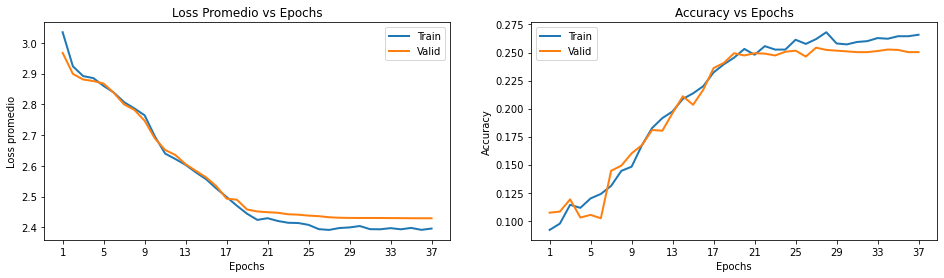

In [ ]:
# dataloader para cada set de datos
BATCH_SIZE = 256
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, 
                          num_workers = 2, pin_memory = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False, 
                          num_workers = 2, pin_memory = True)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, 
                          num_workers = 2, pin_memory = True)

# optimizador
lr = 2e-4
#optimizer = torch.optim.SGD(tiny_vit.parameters(), lr = lr, momentum = 0.9)
optimizer = torch.optim.Adam(tiny_vit.parameters(), lr = lr)

# scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size = 9, gamma = 0.1)

# funcion de perdida
criterion = torch.nn.CrossEntropyLoss()

# epochs
epochs = 70

# patience
patience = 10

# clip
clip = 5

# nombre del modelo
name = 'vit_t16_20'

model_dict = {'model': tiny_vit,
              'trainloader': train_loader,
              'validloader': val_loader,
              'optimizer': optimizer,
              'scheduler': scheduler,
              'criterion': criterion,
              'epochs': epochs,
              'patience': patience,
              'clip': clip,
              'name': name,
              'random_state': random_state,
              'checkpoints_path': checkpoints_folder,
              }

train_acc, train_loss, valid_acc, valid_loss = fit(**model_dict)
graph_metrics(train_loss, train_acc, valid_loss, valid_acc)

#### Evaluación

In [ ]:
# cargamos modelo con mejor desempeño en validacion
model = torch.load(f'{checkpoints_folder}/{name}.pt')

# obtenemos performance en conjunto de validación
accuracy, _, __ = evaluate(model = model, dataloader = val_loader, criterion = criterion)
print(f'Accuracy de la red en conjunto de validación: {accuracy * 100:.2f}%')

Accuracy de la red en conjunto de validación: 25.43%


In [ ]:
# obtenemos performance en conjunto de test
accuracy, _, __ = evaluate(model = model, dataloader = test_loader, criterion = criterion)
print(f'Accuracy de la red en conjunto de test: {accuracy * 100:.2f}%')

Accuracy de la red en conjunto de test: 25.77%


### Transfer learning

Repetimos experimento, pero esta vez realizando *fine tunning* sobre el modelo con clases del nivel superior

In [ ]:
# transfer learning de modelo con 6 clases
name = 'vit_t16_6'
tiny_vit = torch.load(f'{checkpoints_folder}/{name}.pt')

# cambiamos capa de salida
in_features = tiny_vit.header.in_features
tiny_vit.header = nn.Linear(in_features, n_classes)
tiny_vit = tiny_vit.to(device)

tiny_vit

ViT(
  (linear): Linear(in_features=768, out_features=192, bias=True)
  (blocks): ModuleList(
    (0): EncoderBlock(
      (attention): MultiHeadSelfAttention(
        (W_q): ModuleList(
          (0): Linear(in_features=192, out_features=192, bias=True)
          (1): Linear(in_features=192, out_features=192, bias=True)
          (2): Linear(in_features=192, out_features=192, bias=True)
        )
        (W_k): ModuleList(
          (0): Linear(in_features=192, out_features=192, bias=True)
          (1): Linear(in_features=192, out_features=192, bias=True)
          (2): Linear(in_features=192, out_features=192, bias=True)
        )
        (W_v): ModuleList(
          (0): Linear(in_features=192, out_features=192, bias=True)
          (1): Linear(in_features=192, out_features=192, bias=True)
          (2): Linear(in_features=192, out_features=192, bias=True)
        )
        (W_o): Linear(in_features=576, out_features=192, bias=True)
      )
      (mlp): MultiLayerPerceptron(
      

Epoch: 001 	 Avg Train Loss: 2.411 	 Train Accuracy: 27.94 %	Avg Val Loss: 1.722 	 Val Accuracy: 43.32 % 	 Total Val Loss: 20.66
Epoch: 008 	 Avg Train Loss: 1.118 	 Train Accuracy: 63.73 %	Avg Val Loss: 1.394 	 Val Accuracy: 56.35 % 	 Total Val Loss: 16.73
Epoch: 015 	 Avg Train Loss: 0.729 	 Train Accuracy: 76.71 %	Avg Val Loss: 1.190 	 Val Accuracy: 62.37 % 	 Total Val Loss: 14.28
Epoch: 022 	 Avg Train Loss: 0.675 	 Train Accuracy: 78.56 %	Avg Val Loss: 1.178 	 Val Accuracy: 62.53 % 	 Total Val Loss: 14.13
Epoch: 029 	 Avg Train Loss: 0.670 	 Train Accuracy: 78.83 %	Avg Val Loss: 1.180 	 Val Accuracy: 62.76 % 	 Total Val Loss: 14.16
Epoch: 036 	 Avg Train Loss: 0.665 	 Train Accuracy: 78.88 %	Avg Val Loss: 1.180 	 Val Accuracy: 62.93 % 	 Total Val Loss: 14.16
Epoch: 043 	 Avg Train Loss: 0.674 	 Train Accuracy: 79.23 %	Avg Val Loss: 1.180 	 Val Accuracy: 62.96 % 	 Total Val Loss: 14.16

43 épocas efectuadas


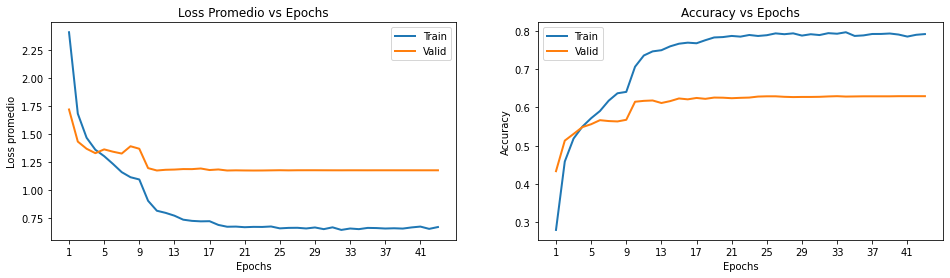

In [ ]:
# dataloader para cada set de datos
BATCH_SIZE = 256
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, 
                          num_workers = 2, pin_memory = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False, 
                          num_workers = 2, pin_memory = True)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, 
                          num_workers = 2, pin_memory = True)

# optimizador
lr = 2e-4
#optimizer = torch.optim.SGD(tiny_vit.parameters(), lr = lr, momentum = 0.9)
optimizer = torch.optim.Adam(tiny_vit.parameters(), lr = lr)

# scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size = 9, gamma = 0.1)

# funcion de perdida
criterion = torch.nn.CrossEntropyLoss()

# epochs
epochs = 70

# patience
patience = 10

# clip
clip = 5

# nombre del modelo
name = 'vit_t16_20'

model_dict = {'model': tiny_vit,
              'trainloader': train_loader,
              'validloader': val_loader,
              'optimizer': optimizer,
              'scheduler': scheduler,
              'criterion': criterion,
              'epochs': epochs,
              'patience': patience,
              'clip': clip,
              'name': name,
              'random_state': random_state,
              'checkpoints_path': checkpoints_folder,
              }

train_acc, train_loss, valid_acc, valid_loss = fit(**model_dict)
graph_metrics(train_loss, train_acc, valid_loss, valid_acc)

#### Evaluación

In [ ]:
# cargamos modelo con mejor desempeño en validacion
model = torch.load(f'{checkpoints_folder}/{name}.pt')

# obtenemos performance en conjunto de validación
accuracy, _, __ = evaluate(model = model, dataloader = val_loader, criterion = criterion)
print(f'Accuracy de la red en conjunto de validación: {accuracy * 100:.2f}%')

Accuracy de la red en conjunto de validación: 62.96%


In [ ]:
# obtenemos performance en conjunto de test
accuracy, _, __ = evaluate(model = model, dataloader = test_loader, criterion = criterion)
print(f'Accuracy de la red en conjunto de test: {accuracy * 100:.2f}%')

Accuracy de la red en conjunto de test: 53.46%


## 82 clases

Generamos dataframe relevante al problema

In [ ]:
metadata_low = gen_valsplit(metadata, class_level = 'low', val_size = .2)
n_classes = len(metadata_low['labels'].unique())
metadata_low.head()

,img_name,split,labels
853,Bow_Pose_or_Dhanurasana_/381.jpg,train,4
9720,Plow_Pose_or_Halasana_/175.jpg,train,45
16500,Wide-Legged_Forward_Bend_pose_or_Prasarita_Pad...,train,77
12457,Split pose/2_10.jpg,train,58
4184,Downward-Facing_Dog_pose_or_Adho_Mukha_Svanasa...,train,17


Comenzamos calculando la media y desviación estándar de los datos

In [ ]:
train_dataset = YogaDataset(root = './Images', metadata = metadata_low, split = 'train', transform = transforms.Compose([transforms.ToTensor()]))
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = False, num_workers = 2, pin_memory = True)

nb_samples = 0.
channel_mean = torch.Tensor([0., 0., 0.])
channel_std = torch.Tensor([0., 0., 0.])
for batch in train_loader:
    images, labels = batch
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(2)*images.size(3), 3)
    for i in range(3):
        channel_mean[i]+=images[:, :, i].mean(1).sum(0)
        channel_std[i]+=images[:, :, i].std(1).sum(0)
    nb_samples += batch_samples

channel_mean /= nb_samples
channel_std /= nb_samples

print(f'Medias: f{channel_mean}')
print(f'Std: {channel_std}')

Medias: ftensor([0.6441, 0.6441, 0.6441])
Std: tensor([0.2381, 0.2381, 0.2381])


Normalizamos los datos usando los estadísticos calculados

In [ ]:
train_transformations = transforms.Compose([
                  transforms.RandomCrop((224, 224)),
                  transforms.RandAugment(num_ops = 2, magnitude = 0),
                  transforms.ToTensor(),
                  transforms.Normalize(mean = channel_mean, 
                                       std = channel_std),
                                       ])

eval_transformations = transforms.Compose([
                  transforms.CenterCrop((224, 224)),
                  transforms.ToTensor(),
                  transforms.Normalize(mean = channel_mean, 
                                       std = channel_std), 
                                       ])

train_dataset = YogaDataset(root = './Images', metadata = metadata_low, split = 'train', transform = train_transformations)
val_dataset = YogaDataset(root = './Images', metadata = metadata_low, split = 'validation', transform = eval_transformations)
test_dataset = YogaDataset(root = './Images', metadata = metadata_low, split = 'test', transform = eval_transformations)

### Fit

In [ ]:
tiny_vit = ViT(img_size = 224, 
            n_channels = 3, 
            patch_size = 16, 
            embedding_dim = 192, 
            mlp_dim = 768, 
            n_blocks = 12, 
            heads = 3, 
            n_classes = n_classes,
            dropout = 0.1,
            dropout_2 = 0,
            )
tiny_vit.to(device)

ViT(
  (linear): Linear(in_features=768, out_features=192, bias=True)
  (blocks): ModuleList(
    (0): EncoderBlock(
      (attention): MultiHeadSelfAttention(
        (W_q): ModuleList(
          (0): Linear(in_features=192, out_features=192, bias=True)
          (1): Linear(in_features=192, out_features=192, bias=True)
          (2): Linear(in_features=192, out_features=192, bias=True)
        )
        (W_k): ModuleList(
          (0): Linear(in_features=192, out_features=192, bias=True)
          (1): Linear(in_features=192, out_features=192, bias=True)
          (2): Linear(in_features=192, out_features=192, bias=True)
        )
        (W_v): ModuleList(
          (0): Linear(in_features=192, out_features=192, bias=True)
          (1): Linear(in_features=192, out_features=192, bias=True)
          (2): Linear(in_features=192, out_features=192, bias=True)
        )
        (W_o): Linear(in_features=576, out_features=192, bias=True)
      )
      (mlp): MultiLayerPerceptron(
      

Epoch: 001 	 Avg Train Loss: 4.439 	 Train Accuracy: 3.36 %	Avg Val Loss: 4.342 	 Val Accuracy: 3.24 % 	 Total Val Loss: 52.10
Epoch: 008 	 Avg Train Loss: 4.168 	 Train Accuracy: 4.75 %	Avg Val Loss: 4.180 	 Val Accuracy: 4.66 % 	 Total Val Loss: 50.16
Epoch: 015 	 Avg Train Loss: 3.902 	 Train Accuracy: 8.74 %	Avg Val Loss: 4.039 	 Val Accuracy: 7.54 % 	 Total Val Loss: 48.47
Epoch: 022 	 Avg Train Loss: 3.774 	 Train Accuracy: 10.63 %	Avg Val Loss: 3.956 	 Val Accuracy: 9.46 % 	 Total Val Loss: 47.47
Epoch: 029 	 Avg Train Loss: 3.746 	 Train Accuracy: 11.35 %	Avg Val Loss: 3.946 	 Val Accuracy: 9.49 % 	 Total Val Loss: 47.35
Epoch: 034 	 Avg Train Loss: 3.745 	 Train Accuracy: 11.09 %
34 épocas efectuadas


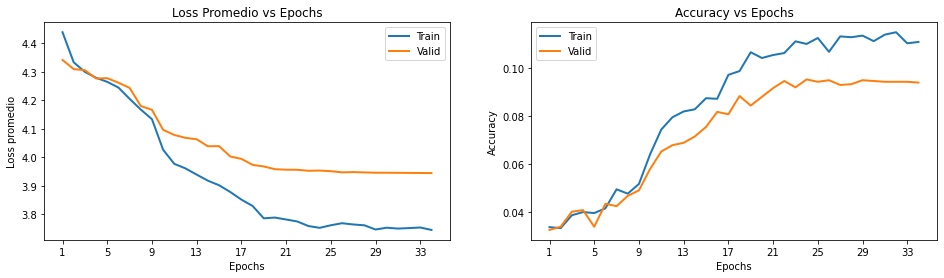

In [ ]:
# dataloader para cada set de datos
BATCH_SIZE = 256
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, 
                          num_workers = 2, pin_memory = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False, 
                          num_workers = 2, pin_memory = True)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, 
                          num_workers = 2, pin_memory = True)

# optimizador
lr = 2e-4
#optimizer = torch.optim.SGD(tiny_vit.parameters(), lr = lr, momentum = 0.9)
optimizer = torch.optim.Adam(tiny_vit.parameters(), lr = lr)

# scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size = 9, gamma = 0.1)

# funcion de perdida
criterion = torch.nn.CrossEntropyLoss()

# epochs
epochs = 70

# patience
patience = 10

# clip
clip = 5

# nombre del modelo
name = 'vit_t16_82'

model_dict = {'model': tiny_vit,
              'trainloader': train_loader,
              'validloader': val_loader,
              'optimizer': optimizer,
              'scheduler': scheduler,
              'criterion': criterion,
              'epochs': epochs,
              'patience': patience,
              'clip': clip,
              'name': name,
              'random_state': random_state,
              'checkpoints_path': checkpoints_folder,
              }

train_acc, train_loss, valid_acc, valid_loss = fit(**model_dict)
graph_metrics(train_loss, train_acc, valid_loss, valid_acc)

#### Evaluación

In [ ]:
# cargamos modelo con mejor desempeño en validacion
model = torch.load(f'best_models/{name}.pt')

# obtenemos performance en conjunto de validación
accuracy, _, __ = evaluate(model = model, dataloader = val_loader, criterion = criterion)
print(f'Accuracy de la red en conjunto de validación: {accuracy * 100:.2f}%')

Accuracy de la red en conjunto de validación: 9.52%


In [ ]:
# obtenemos performance en conjunto de test
accuracy, _, __ = evaluate(model = model, dataloader = test_loader, criterion = criterion)
print(f'Accuracy de la red en conjunto de test: {accuracy * 100:.2f}%')

Accuracy de la red en conjunto de test: 9.09%


### Transfer learning

Repetimos experimento, pero esta vez realizando *fine tunning* sobre el modelo con clases del nivel superior

In [ ]:
# transfer learning de modelo con 6 clases
name = 'vit_t16_6'
tiny_vit = torch.load(f'{checkpoints_folder}/{name}.pt', map_location = device)

# cambiamos capa de salida
in_features = tiny_vit.header.in_features
tiny_vit.header = nn.Linear(in_features, n_classes)
tiny_vit = tiny_vit.to(device)

tiny_vit

ViT(
  (linear): Linear(in_features=768, out_features=192, bias=True)
  (blocks): ModuleList(
    (0): EncoderBlock(
      (attention): MultiHeadSelfAttention(
        (W_q): ModuleList(
          (0): Linear(in_features=192, out_features=192, bias=True)
          (1): Linear(in_features=192, out_features=192, bias=True)
          (2): Linear(in_features=192, out_features=192, bias=True)
        )
        (W_k): ModuleList(
          (0): Linear(in_features=192, out_features=192, bias=True)
          (1): Linear(in_features=192, out_features=192, bias=True)
          (2): Linear(in_features=192, out_features=192, bias=True)
        )
        (W_v): ModuleList(
          (0): Linear(in_features=192, out_features=192, bias=True)
          (1): Linear(in_features=192, out_features=192, bias=True)
          (2): Linear(in_features=192, out_features=192, bias=True)
        )
        (W_o): Linear(in_features=576, out_features=192, bias=True)
      )
      (mlp): MultiLayerPerceptron(
      

Epoch: 001 	 Avg Train Loss: 4.146 	 Train Accuracy: 8.45 %	Avg Val Loss: 3.358 	 Val Accuracy: 19.51 % 	 Total Val Loss: 40.30
Epoch: 008 	 Avg Train Loss: 1.882 	 Train Accuracy: 48.81 %	Avg Val Loss: 2.364 	 Val Accuracy: 39.35 % 	 Total Val Loss: 28.37
Epoch: 015 	 Avg Train Loss: 1.267 	 Train Accuracy: 65.51 %	Avg Val Loss: 2.214 	 Val Accuracy: 45.40 % 	 Total Val Loss: 26.57
Epoch: 021 	 Avg Train Loss: 1.168 	 Train Accuracy: 68.16 %
21 épocas efectuadas


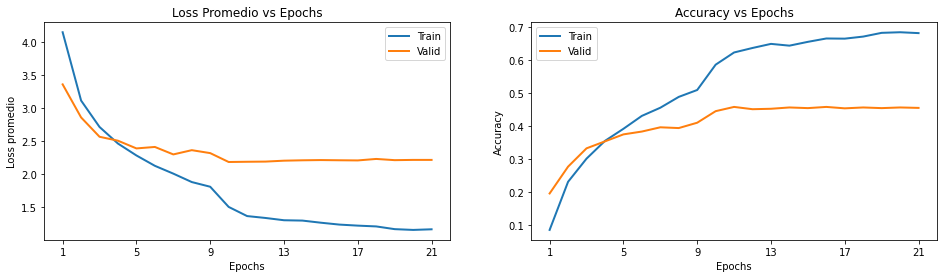

In [ ]:
# dataloader para cada set de datos
BATCH_SIZE = 256
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, 
                          num_workers = 2, pin_memory = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False, 
                          num_workers = 2, pin_memory = True)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, 
                          num_workers = 2, pin_memory = True)

# optimizador
lr = 2e-4
#optimizer = torch.optim.SGD(tiny_vit.parameters(), lr = lr, momentum = 0.9)
optimizer = torch.optim.Adam(tiny_vit.parameters(), lr = lr)

# scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size = 9, gamma = 0.1)

# funcion de perdida
criterion = torch.nn.CrossEntropyLoss()

# epochs
epochs = 70

# patience
patience = 10

# clip
clip = 5

# nombre del modelo
name = 'vit_t16_82'

model_dict = {'model': tiny_vit,
              'trainloader': train_loader,
              'validloader': val_loader,
              'optimizer': optimizer,
              'scheduler': scheduler,
              'criterion': criterion,
              'epochs': epochs,
              'patience': patience,
              'clip': clip,
              'name': name,
              'random_state': random_state,
              'checkpoints_path': checkpoints_folder,
              }

train_acc, train_loss, valid_acc, valid_loss = fit(**model_dict)
graph_metrics(train_loss, train_acc, valid_loss, valid_acc)

#### Evaluación

In [ ]:
# cargamos modelo con mejor desempeño en validacion
model = torch.load(f'{checkpoints_folder}/{name}.pt')

# obtenemos performance en conjunto de validación
accuracy, _, __ = evaluate(model = model, dataloader = val_loader, criterion = criterion)
print(f'Accuracy de la red en conjunto de validación: {accuracy * 100:.2f}%')

Accuracy de la red en conjunto de validación: 45.77%


In [ ]:
# obtenemos performance en conjunto de test
accuracy, _, __ = evaluate(model = model, dataloader = test_loader, criterion = criterion)
print(f'Accuracy de la red en conjunto de test: {accuracy * 100:.2f}%')

Accuracy de la red en conjunto de test: 42.54%
